# Tutorial on Diffusion Models


This tutorial seeks to provide a succinct introduction to diffusion models in an interactive fashion.

The main task of diffusion models is to generate samples, $x$, from an *unknown* distribution $p(x)$, from which we only have access to some of its samples $\{x_i \}_{i=0}^n \sim p(x)$. Here $x$ can represent a myriad of different elements, such as images, videos, words, etc, and it is high-dimensional, i.e.,  $x_i \in \mathbb{R}^d$, where $d >> 1$.

As such, the task of sampling from this *unknown* distribution $p(x)$ is two-fold:

1.   estimate $p(x)$, and
2.   sample from $p(x)$.

In this tutorial we will describe how diffusion models are able to perform these tasks.

As we assume that the reader does not have prior knowledge on sampling methods. We will divide this tutorial in two sections:


1.    we assume that $p(x)$ is known (up to a constant), and we present a couple of algorithms showcasing how to **draw** samples from this distribution, and
2.    we will show how to modify these algorithms to also **estimate** $p(x)$ from its **samples**.

For the first stage we will use the paradigm of generating sampling from an easy-to-sample distribution and we will transform it to samples of the target distribution in the one-dimensional case. Then we will extend this idea to higher dimension where the transformation will be a composition of a large amount of small transformations (usually driven by a Stochastic Differential Equation associated with a *diffusion process*, hence the origin of the name).

Then we will use a similar approach but in two-directions. We will consider a noising process which transforms any samples of the target distribution to Gaussian noise, by using a sequence of small transformation that progressively add noise to the samples. Then we will revert this process, so any Gaussian noise can be reverted back to a sample from the target distribution by a sequence of transformation that progressively **denoise**, or extract, the noise.

In [1]:
# @title Imports
from functools import partial
from typing import Any, Callable
import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import tensorflow_datasets as tfds
from tqdm import tqdm

PyTree = Any

### Sampling from $p(x)$.

For simplicity we will start with a simpler problem. Suppose that $x \in \mathbb{R}$ and that $p(x)$ is know.

Our simplified task is to sample from this distribution for an arbitrary $p$. The methodology introduced here will be similar for more complex tasks. In a nutshell the methodology has two steps:

1.   obtain samples from a distribution that it is easy-to-sample, e.g, a uniform distribution, and
2.   transform those samples, so that the results follow the target distribution.

We show below how this usually done in practice for simpler problems.



### Inverse Transform Sampling

One of the simplest algorithms for sampling following a known one-dimensional distribution $p$, is the so called Inverse Transform Sampling. This technique stems from the fact that for any continuous one-dimensional distribution $p$, its cumulative density function
$$
    F_{X}(x) = \int_{-\infty}^x p(s) ds
$$
induces a uniform random variable in $[0, 1]$.

In other words, if a random variable $X \sim p$ then $U := F_{X}(X)$ is an uniform random variable. I.e., $U \sim \mathbb{U}[0,1]$. Now, if $F_X$ in invertible, then we can recover $X$ by transforming $U$ following $X = F_{X}^{-1}(U)$.

This observation is useful to generate samples from $X$:

1.   one draws samples $u_i \sim U$, which can be easily done with any pseudo-random number generator,
2.   and then transform them through $F_X^{-1}$, i.e., $x_i = F_X^{-1}(u_i)$ are such that $x_i \sim X$.


  

In the code below we show how this can be used for sampling from two different distributions.


**Remark:**
This stems from the fact that if $U \sim \mathbb{U}[0, 1]$ and $F: \mathbb{R} \rightarrow [0, 1]$ is a positive, weakly monotonic, and right-continuous function then $X = F^{-1}(U)$ has $F$ as its CDF.

This statement can be proved with a simple calculation: where the CDF of the random variable $X= F^{-1}(U)$ is given by
$$
    F_X(x) := \mathbb{P}(X \leq x) = \mathbb{P}(F^{-1}(U) \leq x) = \mathbb{P}(U \leq F(x)) = F(x),
$$
where we used the fact that as $F$ is right-continuous so we have the following set equality $\{u: F^{-1}(u) \leq x \} = \{u: u \leq F(x) \}$, and the fact that if $u\leq 1$, then $\mathbb{P}(U \leq u) = u$.

Here we demonstrate this approach by sampling from the target distribution
$$p(x) = \frac{\pi}{2} \sin (\pi x)$$
where
$$F_X(x) =  \frac{1}{2}(1 -\cos(\pi x)), $$
and a quick computation shows that
$$F^{-1}_X(u) = \frac{\arccos(1 - 2u)}{\pi}.$$

In [2]:
# Samples u from an uniform distribution.
key = jax.random.PRNGKey(37)
u = jax.random.uniform(key, (20000,))

# Transforms the samples to x, using X = F_{X}^{-1}(U).
x = jnp.arccos(1 - 2*u)/jnp.pi

Now we plot the histograms.

<Figure size 1000x400 with 0 Axes>

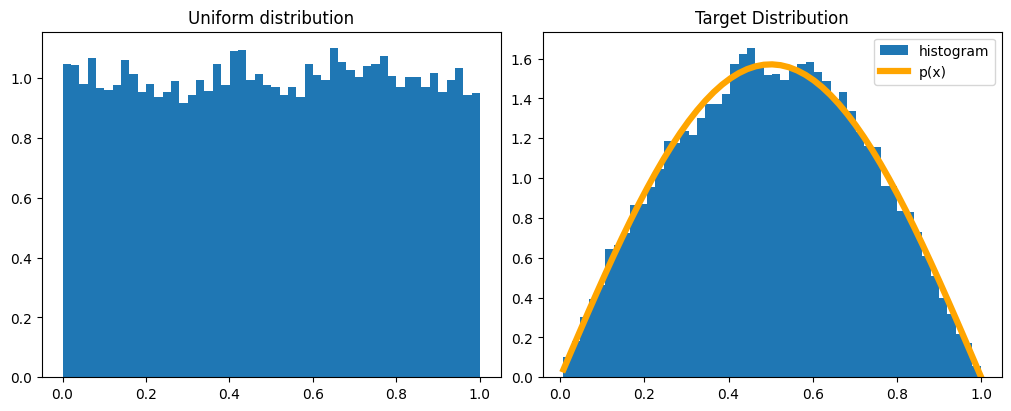

In [3]:
fig = plt.figure(layout="constrained", figsize=(10, 4))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout="constrained")

counts, bins = jnp.histogram(u, bins=50, density=True)
ax[0].hist(bins[:-1], bins, weights=counts, label="histogram")
ax[0].set_title("Uniform distribution")

counts, bins = jnp.histogram(x, bins=50, density=True)
ax[1].hist(bins[:-1], bins, weights=counts, label="histogram")
ax[1].plot(
    bins,
    0.5 * jnp.pi * jnp.sin(jnp.pi * bins),
    linewidth=4.5,
    color="orange",
    label="p(x)",
)
ax[1].set_title("Target Distribution")
ax[1].legend()

 In the left we have the histogram of the uniform distribution and in the right we have the histogram of the transformed samples which approximates the target distribution.

We can repeat this operation for distributions without a compact support, e.g., we can consider
$$ p(x) = \frac{e^{\sqrt{x}}}{2\sqrt{x}},$$
with CDF
$$F_{X}(x) = 1 - e^{-\sqrt{x}},$$
and inverse
$$F_{X}^{-1}(u) = \left ( \log(1 - u)\right)^2$$.

In this case the density will decrease rapidly as $x$ increases.

In [4]:
# Samples u from an uniform distribution.
key = jax.random.PRNGKey(37)
u = jax.random.uniform(key, (1000000,))

# Transforms the samples to x, using X = F_{X}^{-1}(U).
x = jnp.square(jnp.log(1 - u))

<Figure size 1000x400 with 0 Axes>

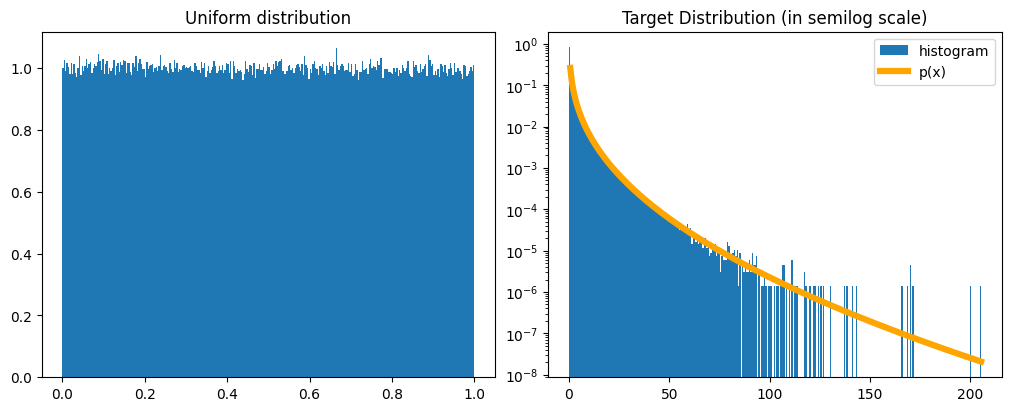

In [5]:
fig = plt.figure(layout="constrained", figsize=(10, 4))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout="constrained")

counts, bins = jnp.histogram(u, bins=300, density=True)
ax[0].hist(bins[:-1], bins, weights=counts, label="histogram")
ax[0].set_title("Uniform distribution")

counts, bins = jnp.histogram(x, bins=300, density=True)
ax[1].hist(bins[:-1], bins, weights=counts, label="histogram")
ax[1].semilogy(
    bins[1:],
    0.5 * jnp.exp(-jnp.sqrt(bins[1:])) / jnp.sqrt(bins[1:] + 0.01),
    color="orange",
    linewidth=4.5,
    label="p(x)",
)
ax[1].set_title("Target Distribution (in semilog scale)")
ax[1].legend()

plt.show()

Here we can also observe how the uniform samples are transformed to the target distribution, which decays rapidily as mentioned above.

### Langevin Sampler

The Inverse Transformation Sampler is simple and efficient; however, it is only restricted to one-dimensional distributions. To handle higher dimension many different approaches have been proposed in the literature.

Among them the Langevin sampler is perhaps one of the most related to diffusion models. The Langevin sampler leverages properties of the Langevin equation at equilibrium, i.e., in the asymptotic limit as $t \rightarrow \infty$.

The [overdamped Langevin equation](https://en.wikipedia.org/wiki/Brownian_dynamics) is usually written as
$$
    dX_{\tau} = -\nabla V(X_{\tau}) d\tau + \sqrt{2} \sigma dW_{\tau},
$$
where $V: \mathbb{R}^d \rightarrow \mathbb{R}^{+}$ is a potential function and $dW_{\tau}$ is a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process), and with initial distribution $X_0 \sim p_o$.

#### Physical meaning of the components

We briefly explain the physical meaning of each term of the overdamped Langevin equation. On the one hand, if there is no stochastic term ($\sigma = 0$), the equation becomes just a gradient flow, i.e., it seeks to push $X_{\tau}$ to the areas that minimizes the potential. E.g., if we consider the quadratic potential centered at the origin $V(x) := \frac{\|x \|^2}{2}$, with minimizer in the origin, thus $-\nabla V$ always points towards the origin. In this case, the gradient flow given by
$$ \dot{X_{\tau}} =  -\nabla V(X_{\tau})$$
will transport $X_{\tau}$ to the origin as $\tau \rightarrow \infty$.
On the other hand, if there is only the stochastic term ($V$ is constant),  the equation becomes a random walk:
$$dX_{\tau} = \sqrt{2} \sigma dW_{\tau},$$
which will randomly explore the full space.

As such, there are two competing forces: one is the potential that seeks to push $X_{\tau}$ to the zones of lowest potential, and there is the stochastic part that injects energy to the system randomly. If $V$ has more than one local minima, then the stochastic part would help the trajectory to "jump" from one basin of attraction to another one.


#### Equilibrium

The main reason to use this equation for transforming samples as we did in the Inverse Transform Sampler lies in the expression for its limiting distribution.
Basically, for any initial distribution if we solve the Langevin equation for long enough, the trajectories will follow a limiting distribution which **only** depends on $V$ and $\sigma$.

We bypass the computation, but we show that for $\tau >> 1$ we have that $X_{\tau} \sim p_{\infty}$, where $p_{\infty}$ is completely determined by the potential and the noise level, and it is given by
$$p_{\infty}(x) = c e^{-V(x)/\sigma^2},$$
where $c$ is a normalizing constant.

This means that we can manipulate $V$ and $\sigma$ so the limiting distribution is our target distribution $p$. Thus by letting $ V = \log p $ and $\sigma = 1$ we have that
$$
    dX_{\tau} = -\nabla \log p(X_{\tau}) d\tau + \sqrt{2}dW_{\tau},
$$
will have as limiting disitribution
$$p_{\infty}(x) = c e^{-V(x)/\sigma^2} = c p(x) = p(x),$$
which is exactly our target distribution.

Then you can use the Langevin equation to sample from an easy-to-sample distribution, and use that sample as an initial condition to solve the SDE, thus evolving the trajectory until the solution has reached the limiting distribution (e.g., at the time horizon $T >> 1$). The resulting state will be a sample of the target distribution.


**Remarks**

The function $\nabla \log p(X_{\tau})$ is usually called the **score function**. As we are considering the derivate of a logarithm, we have that this function is agnostic to normalizations. I.e., suppose that you have $q(x) = c p(x)$, then
$$\nabla \log q(x) = \nabla \log c p(x) =  \nabla \log c + \nabla \log p(x) = \nabla \log p(x),$$
as $\nabla \log c = 0$.

#### Euler-Maruyama Solver

Here we consider a more general SDE which can be written as

$$
    dX_{\tau} = f(X_{\tau}, \tau) d\tau + g(\tau) dW_{\tau},
$$
the main difference is that we allow the drift and the diffusion term to be time-dependent. Now in what follows we implement the Euler-Maruyama solver in Jax.

In [6]:
@partial(jax.jit, static_argnums=(2, 3, 4, 5, 6))
def euler_maruyama_solver(key:jax.Array,
                x_0: jax.Array,
                f: Callable[[jax.Array, jax.Array], jax.Array],
                g: Callable[[jax.Array], jax.Array],
                dt: float=0.001,
                t_final: float=1.,
                return_trajectory: bool=False) -> jax.Array:
    """Solver for the forward equation using Euler-Maruyama.

    Args:
        key: Random seed.
        x_0: Initial condition.
        f: Drift coefficient.
        g: Diffusion coefficient.
        dt: Time step.
        t_final: Time horizon.

    Returns:
        Sample from the target distribution.
    """
    def time_step(carry: tuple[jax.Array, jax.Array], params_time):
        key, x = carry
        t, dt = params_time
        key, subkey = jax.random.split(key)
        # Now we run the kernel using Euler-Maruyama
        diff = g(t)
        deltaW = jax.random.normal(key=subkey, shape=(x.shape))
        drift = f(x, t)
        x = x + dt*drift + jnp.sqrt(dt)*diff*deltaW
        return (key, x), (x)

    key, _ = jax.random.split(key)
    n_steps = int(1/dt)
    time_steps = t_final * jnp.arange(1, n_steps)/(n_steps-1)
    # We allow for non-uniform discretization in time.
    delta_t = time_steps[1:] - time_steps[:-1]
    params_time = jnp.stack([time_steps[:-1], delta_t], axis=1)
    # Initial condition.
    carry = (key, x_0)
    (_, samples), trajectory = jax.lax.scan(time_step, carry, params_time)
    # Whether to return the full trajectory of just the last element.
    if return_trajectory:
      return trajectory
    else:
      return samples

Thus we can manipulate $f$ and $g$ appropiately following the Langevin equation above. Here we define a density centered in the sphere of radious 1.

$$p(x):= c \cdot e^{-| \| x\|^2 - 1 |}.$$

Again, we don't need to prescribe the normalization constant.

Here we also leverage the jax transformation to compute the the score function of $p$,
$$\nabla_x \log p(x),$$
given that $f$ is supposed to be also time dependent so we add a dummy variable in the definition of the functions.


In [7]:
# Function proportional to the target distribution.
def p(x, t):
  return jnp.exp(-jnp.abs(jnp.sum(jnp.square(x)) - 1.)) + 0.*jnp.sum(t)

# Noise level.
def sigma(t):
  return 0.*t + jnp.sqrt(2)*0.001

logp = lambda x,t: jnp.log(p(x,t))

# Compute the gradient of the log-likely hood or score function.
nablaV = jax.grad(logp, argnums=0)

We define the dimension and the number of samples to be drawn and we vectorize the sampler.

In [8]:
# Dimension of the samples.
d = 3
# Defines the number of samples.
n_samples = 1000

# We vectorize the sampler to draw several samples simultaneously.
sampler_vectorized = jax.vmap(
    partial(
        euler_maruyama_solver, f=nablaV, g=sigma, dt=0.001, t_final=40
        ),
    in_axes=(0, 0), out_axes=0)

Now we perform the same process as before:

1.   we sample from an easy-to-sample distribution, here is a simple Normal distribution, and
2.   we transform the samples using them as initial condition to the SDE solver.



In [9]:
# It creates the array of random seeds.
key_array = jax.random.split(key, n_samples)
# We sample from the initial condition.
x_0 = jax.random.normal(key, shape=(n_samples, d))
# We solve the Langevin equation in vectorized form.
samples = sampler_vectorized(key_array, x_0)

We can plot the samples, which, unsurprisingly, concentrate around the sphere of radius 1.

In [10]:
fig = go.Figure(data=[go.Scatter3d(x=samples[:,0], y=samples[:,1], z=samples[:,2],
                                   mode='markers',
                                   marker=dict(size=3,opacity=0.8)),])
fig.show()

Here we also observe that the starting points (in red) were taken from a Gaussian disctribution, and they were transformed to the samples of the target one.

In [11]:
fig = go.Figure(data=[go.Scatter3d(x=samples[:,0], y=samples[:,1], z=samples[:,2],
                                   mode='markers',
                             marker=dict(size=3,opacity=0.8)),
                go.Scatter3d(x=x_0[:,0], y=x_0[:,1], z=x_0[:,2],
                                   mode='markers',
                             marker=dict(size=3,opacity=0.8)),])
fig.show()


You can easily choose a different target distribution, for example using an ellipsoid.

In [12]:
A = jnp.array([[1.5, 0., 0.],[0., 0.75, 0.],[0., 0., 1.]])
def p(x, t):
  return jnp.exp(-jnp.abs(jnp.sum(jnp.square(A @ x)) - 4.)) + 0.*jnp.sum(t)

logp = lambda x,t: jnp.log(p(x,t))

nablaV = jax.grad(logp, argnums=0)

# As we changed the density and therefore the potential we also change the
# equation.
sampler_vectorized = jax.vmap(
    partial(
        euler_maruyama_solver, f=nablaV, g=sigma, dt=0.001, t_final=10
        ),
    in_axes=(0, 0), out_axes=0)

In [13]:
# Defines the number of samples.
n_samples = 2000
# It creates the array of random seeds.
key_array = jax.random.split(key, n_samples)
# We sample from the initial condition.
x_0 = jax.random.normal(key, shape=(n_samples, d))
# Sampling by solving the Langevin equation.
samples = sampler_vectorized(key_array, x_0)

And we can plot the starting samples of the Langevin equation and the target samples.

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=samples[:,0], y=samples[:,1], z=samples[:,2],
                                   mode='markers',
                             marker=dict(size=3,opacity=0.8)),
                go.Scatter3d(x=x_0[:,0], y=x_0[:,1], z=x_0[:,2],
                                   mode='markers',
                             marker=dict(size=3,opacity=0.4)),])
fig.show()

## Learning the distribution.

Thus far, we have addressed the initial question: how to sample from a known target distribution. To achieve this, we employed the paradigm of transforming samples from an easy-to-sample distribution into samples of the target distribution.

The subsequent question arises: what if the target distribution is *unknown*? Fortunately, diffusion models offer an efficient and elegant solution by learning the *score function* associated to the distribution.

Diffusion models exploit the same principles used for generating samples with the Langevin solver discussed earlier.

We started with a arbitrary but easy-to-sample distribution, and by evolving the SDE we samples of the limiting distribution, which is equal to the target distribution by manipulating the drift and diffusion coefficients. Here, we do **start** from the **target distribution** and we manipulate the SDE so the limiting distribution is the simple-to-sample distribution. Then we seek to reverse this process: we sample from the easy-to-sample distribution and the **evolve** the SDE **backwards** to obtain a sample of the target one. 

Now, instead of integrating for a long time, we leverage the fact that drift and diffusion coefficients are time dependent to increase the noise much faster. In particular, we choose the following functions

In [15]:
beta_min = 0.001
beta_max = 500

def beta(t: jax.Array) -> jax.Array:
  return beta_min + t*(beta_max - beta_min)

def f(x: jax.Array, t: jax.Array) -> jax.Array:
  return -0.5*beta(t)*x

def g(t: jax.Array) -> jax.Array:
  return jnp.sqrt(beta(t))

Let's see an example of this. We load the picture of a dog, and then we will run a similar SDE but using the image of the dog as an initial condition.

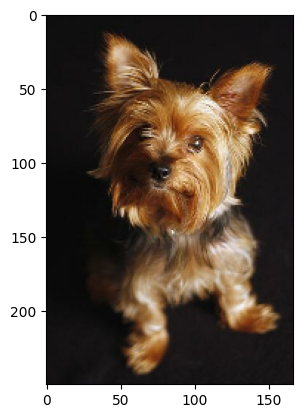

In [16]:
data_set = tfds.load('stanford_dogs', split='train')
dog = next(iter(data_set))
dog_image = np.array(dog['image'])[::2,::2]
plt.imshow(dog_image)

Now we define a slightly different implementation of the solver, as we want to obtain the full trajectory of the noising process.

In [17]:
# We take the image of the dog an initial condition.
x_0 = dog_image.astype(np.float64).reshape((-1,)) / 256.
rng = jax.random.PRNGKey(0)
# Solves the forward SDE.
trajectory = euler_maruyama_solver(rng, x_0, f, g, return_trajectory=True)

Now we can plot how our image of the dog becomes increasingly noised. In this case we plot only one RGB channel to make things easier.

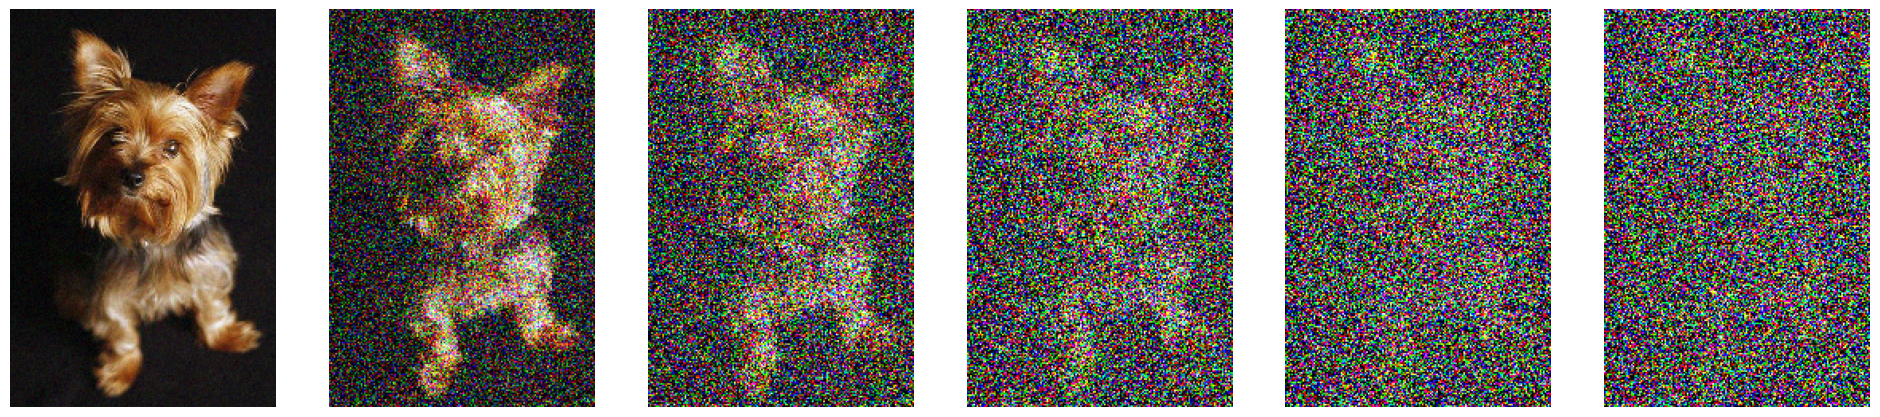

In [18]:
traj_image = trajectory.reshape((-1, *dog_image.shape))
fig, axes = plt.subplots(1, 6, figsize=(24, 8))  # Adjust figsize for desired dimensions
idx = [0, 20, 40, 60, 80, 97]
for i, ax in enumerate(axes):
    ax.imshow(traj_image[idx[i],:,:])
    ax.axis('off')

As we can see the picture of the dog become incresingly noised as we progress **forward** in the simulation of the SDE. Now, diffusion models seek to reverse this process. Fortunately, it is known that for the SDE

$$
 dX_{\tau} = f(X_{\tau}, \tau) d\tau + g(\tau) dW_{\tau},
$$

can be reversed in time, by solving the following SDE backwards
$$
 dX_{\tau} = \left ( f(X_{\tau}, \tau) - \nabla_x \log p(X_{\tau}, \tau) \right ) d\tau + g(\tau) d\bar{W}_{\tau},
$$
where $d\bar{W}_{\tau}$ is a backward Wiener process, and $p(X_{\tau}, \tau)$ is the marginal distribution of the full process at time $\tau$, i.e., $X_{\tau} \sim  p(X_{\tau}, \tau)$.

The question becomes on how to compute the score function. Here is where the key component of diffusion models comes to light: the Tweedie's formula. If

$$X_{\tau} = s(\tau) X_{0} + \varepsilon_{\tau}\,,\quad\text{with}\quad \varepsilon_{\tau}\sim N(0,\sigma^{2}(\tau)I)\,.$$

then we have that

$$\mathbb{E}[X_{0}|X_{\tau}] = \frac{X_{\tau} + \sigma^{2}(\tau)\nabla_{x}\log{p(X_{\tau}, \tau)}}{s(\tau)} \quad\Rightarrow\quad\nabla_{x}\log{p(X_{\tau}, \tau)} = \frac{s(\tau)\mathbb{E}[X_{0}|X_{\tau}] - X_{\tau}}{\sigma^{2}(\tau)}\,.$$

where $\mathbb{E}[X_{0}|X_{\tau}]$ is interpreted as denoiser. It takes the noisy image $X_{\tau}$ and computes the maximum likelyhood of the original image $X_0$. Now, we can approximate this denoiser by a neural network, such that
$$D_{\theta} (x + \sigma \varepsilon, \sigma) \approx x$$.

This allows us to build this score function by leveraging the denoiser, which is parametrized by a neural network, and then we can solve the backwards SDE introduced above to sample from the target distribution.

We will consider the data that was generated before as our target distribution. For an example using images the reader can take a look at this [colab](https://github.com/google-research/swirl_dynamics/projects/probabilistic_diffusion/colabs/demo.ipynb). Unfortunately, one needs a non-negligeable amount of scaffolding for more realistic applications. Instead here we focus on a fully self-contained implementation.

We start by defining our denoiser model.


In [19]:
class Denoiser(nn.Module):
  """A simple model MLPs and a Fourier Embedding."""

  @nn.compact
  def __call__(self, x, sigma):
    in_size = x.shape[1]
    n_hidden = 256
    sigma = jnp.concatenate([sigma,
                             jnp.cos(2 * jnp.pi * sigma),
                             jnp.sin(2 * jnp.pi * sigma),
                             jnp.cos(4 * jnp.pi * sigma),
                             jnp.sin(4 * jnp.pi * sigma)], axis=1)
    x = jnp.concatenate([x, sigma], axis=1)
    x = nn.Dense(n_hidden)(x)
    x = nn.selu(x)
    x = nn.Dense(n_hidden)(x)
    x = nn.selu(x)
    x = nn.Dense(n_hidden)(x)
    x = nn.selu(x)
    x = nn.Dense(in_size)(x)
    return x

As before, we consider our schedule, which provides the expressions for $f$ and $g$, and also for the scaling factor $s(t)$ and the noise level $\sigma(t)$.

In [99]:
beta_min = 0.001
beta_max = 3

def beta(t: jax.Array) -> jax.Array:
  return beta_min + t*(beta_max - beta_min)

def int_beta(t: jax.Array) -> jax.Array:
  """Integral of beta from 0 to t."""
  return t*beta_min + 0.5 * t**2 * (beta_max - beta_min)

def f(x: jax.Array, t: jax.Array) -> jax.Array:
  return -0.5*beta(t)*x

def g(t: jax.Array) -> jax.Array:
  return jnp.sqrt(beta(t))

def s(t: jax.Array) -> jax.Array:
  return jnp.exp(-0.5 * int_beta(t))

def sigma2(t: jax.Array) -> jax.Array:
  return 1 - jnp.exp(-int_beta(t))

Here we initialize the denoiser model and its parameters.

In [100]:
import optax

batch_size = 50

# Define dummy data for initailization.
x, time = jnp.zeros((batch_size, d)), jnp.ones((batch_size, 1))

# Initialize the model weights.
denoiser = Denoiser()
params = denoiser.init(rng, x, time)

# Initialize the optimizer and its state.
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)

We create the loss function.

In [138]:
def loss_fn(
    params: PyTree, model: nn.Module, rng: jax.Array, batch: jax.Array
) -> jax.Array:
  """loss function to be used to train the model

  Args:
      params: the current weights of the model
      model: the score function
      rng: random number generator from jax
      batch: a batch of samples from the training data, representing samples
        from \mu_text{data}, shape (J, N)

  Returns:
      The value of the loss function defined above.
  """
  rng, step_rng = jax.random.split(rng)
  batch_size = batch.shape[0]
  num_steps = 100
  t = jax.random.randint(step_rng, (batch_size, 1), 1, num_steps) / (
      num_steps - 1
  )
  # Extract the standard deviation from the schedule.
  std  = jnp.sqrt((1-s(t)**2)/s(t)**2)
  rng, step_rng = jax.random.split(rng)
  noise = jax.random.normal(step_rng, batch.shape)
  xt =  batch + noise * std
  output = model.apply(params, xt, std)
  loss = jnp.mean((batch - output) ** 2)
  return loss

<>:4: SyntaxWarning:

invalid escape sequence '\m'

<>:4: SyntaxWarning:

invalid escape sequence '\m'

/var/folders/sq/x31knxg535df53ttnx51j7pm0000gp/T/ipykernel_71465/2399790973.py:4: SyntaxWarning:

invalid escape sequence '\m'



And the update step, which will update the weights of the networks contained in the PyTree params (this is a tree that contains all the internal structure of the network, including the values of the weights).

In [139]:
@partial(jax.jit, static_argnums=[4])
def update_step(
    params: PyTree,
    rng: jax.Array,
    batch: jax.Array,
    opt_state: optax.OptState,
    model: nn.Module,
) -> tuple[jax.Array, PyTree, optax.OptState]:
  """Updates the parameters based on the gradient of the loss function.

   Takes the gradient of the loss function and updates the model weights
   (params) using it.

  Args:
      params: The current weights of the model.
      rng: Random seed from jax.
      batch: A batch of samples from the training data, representing samples
        from p_{\text{data}}, shape (d, N)
      opt_state: the internal state of the optimizer
      model: the score function

  Returns:
   A tuple with the value of the loss function (for metrics), the new parameters
   and the new
    optimizer state
  """
  val, grads = jax.value_and_grad(loss_fn)(params, model, rng, batch)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return val, params, opt_state

Now we can run a very simple training loop.

In [140]:
N_epochs = 3_000
train_size = samples.shape[0]
batch_size = 20
steps_per_epoch = train_size // batch_size
for k in tqdm(range(N_epochs)):
  rng, step_rng = jax.random.split(rng)
  # Permutes the data at each epoch.
  data = jax.random.permutation(step_rng, samples, axis=0)
  data = jnp.reshape(data, (steps_per_epoch, batch_size, data.shape[-1]))
  losses = []
  for batch in data:
    rng, step_rng = jax.random.split(rng)
    loss, params, opt_state = update_step(
        params, step_rng, batch, opt_state, denoiser
    )
    losses.append(loss)
  mean_loss = jnp.mean(jnp.array(losses))
  if k % 1000 == 0:
    print("Epoch %d \t, Mean Loss %f " % (k, mean_loss))

  0%|          | 4/3000 [00:00<04:12, 11.85it/s]

Epoch 0 	, Mean Loss 0.372689 


 34%|███▎      | 1005/3000 [00:46<01:40, 19.85it/s]

Epoch 1000 	, Mean Loss 0.368462 


 67%|██████▋   | 2003/3000 [01:30<00:43, 23.17it/s]

Epoch 2000 	, Mean Loss 0.350959 


100%|██████████| 3000/3000 [02:14<00:00, 22.28it/s]


We define the score fucntion by leveraing the proper normalization stemming from the choice of $f$ ang $g$.

In [155]:
def trained_score(x, t):
  x_t = x/s(t)
  return (s(t) * denoiser.apply(params, x_t, jnp.sqrt(sigma2(t)/s(t)**2)) - x) / sigma2(t)

Now we need to define a different solver that solves the SDE backwards.

In [156]:
R = 1000
train_ts = jnp.arange(1, R)/(R-1)

@partial(jax.jit, static_argnums=(1,2,3,4,5))
def sde_solver_backwards(key:jax.Array,
                grad_log: Callable[[jax.Array], jax.Array],
                g: Callable[[jax.Array], jax.Array],
                f: Callable[[jax.Array, jax.Array], jax.Array],
                N: int, n_samples: int,
                ts: jax.Array=train_ts) -> jax.Array:
    """ Euler-Maruyama solver for the backwards SDE.

    Args:
        key: random number generator
        grad_log: drift term for the SDE (here the score)
        N: dimension of the problem
        dt: time step
        x_0: initial point
    """
    def lmc_step_with_kernel(carry, params_time):
        key, x = carry
        t, dt = params_time
        key, subkey = jax.random.split(key)
        # Now we run the kernel using Euler-Maruyama
        disp = g(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -f(x, 1-t) + grad_log(x, 1 - t)*disp**2
        x = x + dt*drift + jnp.sqrt(dt)*disp*jax.random.normal(key=subkey, shape=(x.shape))
        return (key, x), ()
    key, subkey = jax.random.split(key)
    dts = ts[1:] - ts[:-1]
    params_time = jnp.stack([ts[:-1], dts], axis=1)
    # Sampling the terminal condition with the correct std.
    x_1 = jnp.sqrt(sigma2(1.)) * jax.random.normal(subkey, shape=(n_samples, N))
    carry = (key, x_1)
    (_, samples), _ = jax.lax.scan(lmc_step_with_kernel, carry, params_time)
    return x_1, samples

Now we can use our learned score function (which is estimated from samples) to run the

In [157]:
x_1, gen_samples = sde_solver_backwards(step_rng, trained_score, g, f, 3, 5000)

And we can plot the generated samples. Where we observe that we were able to capture the general geometry of the distribution.

In [158]:
fig = go.Figure(data=[go.Scatter3d(x=gen_samples[:,0], y=gen_samples[:,1], z=gen_samples[:,2],
                                   mode='markers',
                             marker=dict(size=3,opacity=0.8)),])
fig.show()

In this case we can also see the samples from the easy-to-sample distribution.

In [91]:
fig = go.Figure(data=[go.Scatter3d(x=gen_samples[:,0], y=gen_samples[:,1], z=gen_samples[:,2],
                                   mode='markers',
                             marker=dict(size=3,opacity=0.8)),
                go.Scatter3d(x=x_1[:,0], y=x_1[:,1], z=x_1[:,2],
                                   mode='markers',
                             marker=dict(size=3,opacity=0.4)),])
fig.show()